## Importing the libraries 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import datetime as dt
from sklearn.cluster import KMeans
from haversine import haversine
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import optuna
import sklearn.metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut, TimeSeriesSplit
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go 
import geopandas as gpd
import folium

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
seed = 42

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/align-2019-2020-emission-values-with-2021/__results__.html
/kaggle/input/align-2019-2020-emission-values-with-2021/submission.csv
/kaggle/input/align-2019-2020-emission-values-with-2021/__resultx__.html
/kaggle/input/align-2019-2020-emission-values-with-2021/__notebook__.ipynb
/kaggle/input/align-2019-2020-emission-values-with-2021/__output__.json
/kaggle/input/align-2019-2020-emission-values-with-2021/custom.css
/kaggle/input/align-2019-2020-emission-values-with-2021/__results___files/__results___8_1.png
/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv
/kaggle/input/pgs320-country-location-data/location_lat_long.csv
/kaggle/input/the-og-submission-cat-and-rf/the_og_submission_cat_and_rf.csv


In [2]:
pd.set_option('display.max_columns', None)

## Exploratory Data Analysis

In [3]:
# train = pd.read_csv("/kaggle/input/playground-series-s3e20/train.csv", index_col="ID_LAT_LON_YEAR_WEEK")
# test = pd.read_csv("/kaggle/input/playground-series-s3e20/test.csv", index_col="ID_LAT_LON_YEAR_WEEK")
train = pd.read_csv("/kaggle/input/playground-series-s3e20/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e20/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s3e20/sample_submission.csv")

In [4]:
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.

In [5]:
train.shape, test.shape

((79023, 76), (24353, 75))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [7]:
pd.set_option("display.max_rows", None)

In [8]:
print("\tTRAIN\n", (lambda x: x.isnull().sum()/len(x)*100)(train), "\n\tTEST\n", (lambda x: x.isnull().sum()/len(x)*100)(test))

	TRAIN
 ID_LAT_LON_YEAR_WEEK                                         0.000000
latitude                                                     0.000000
longitude                                                    0.000000
year                                                         0.000000
week_no                                                      0.000000
SulphurDioxide_SO2_column_number_density                    18.487023
SulphurDioxide_SO2_column_number_density_amf                18.487023
SulphurDioxide_SO2_slant_column_number_density              18.487023
SulphurDioxide_cloud_fraction                               18.487023
SulphurDioxide_sensor_azimuth_angle                         18.487023
SulphurDioxide_sensor_zenith_angle                          18.487023
SulphurDioxide_solar_azimuth_angle                          18.487023
SulphurDioxide_solar_zenith_angle                           18.487023
SulphurDioxide_SO2_column_number_density_15km               18.487023
CarbonMonoxi

In [9]:
pd.set_option("display.max_rows", 10)

Now we will combine the test and train datasets as it will be easier to do feature engg.

In [10]:
train['type'] = "train"
test['type'] = "test"
df = pd.concat([train,test], axis = 0, ignore_index=True)

In [11]:
df

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,type
0,ID_-0.510_29.290_2019_00,-0.510,29.290,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,train
1,ID_-0.510_29.290_2019_01,-0.510,29.290,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.000030,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,train
2,ID_-0.510_29.290_2019_02,-0.510,29.290,2019,2,0.000514,0.7481

<Axes: >

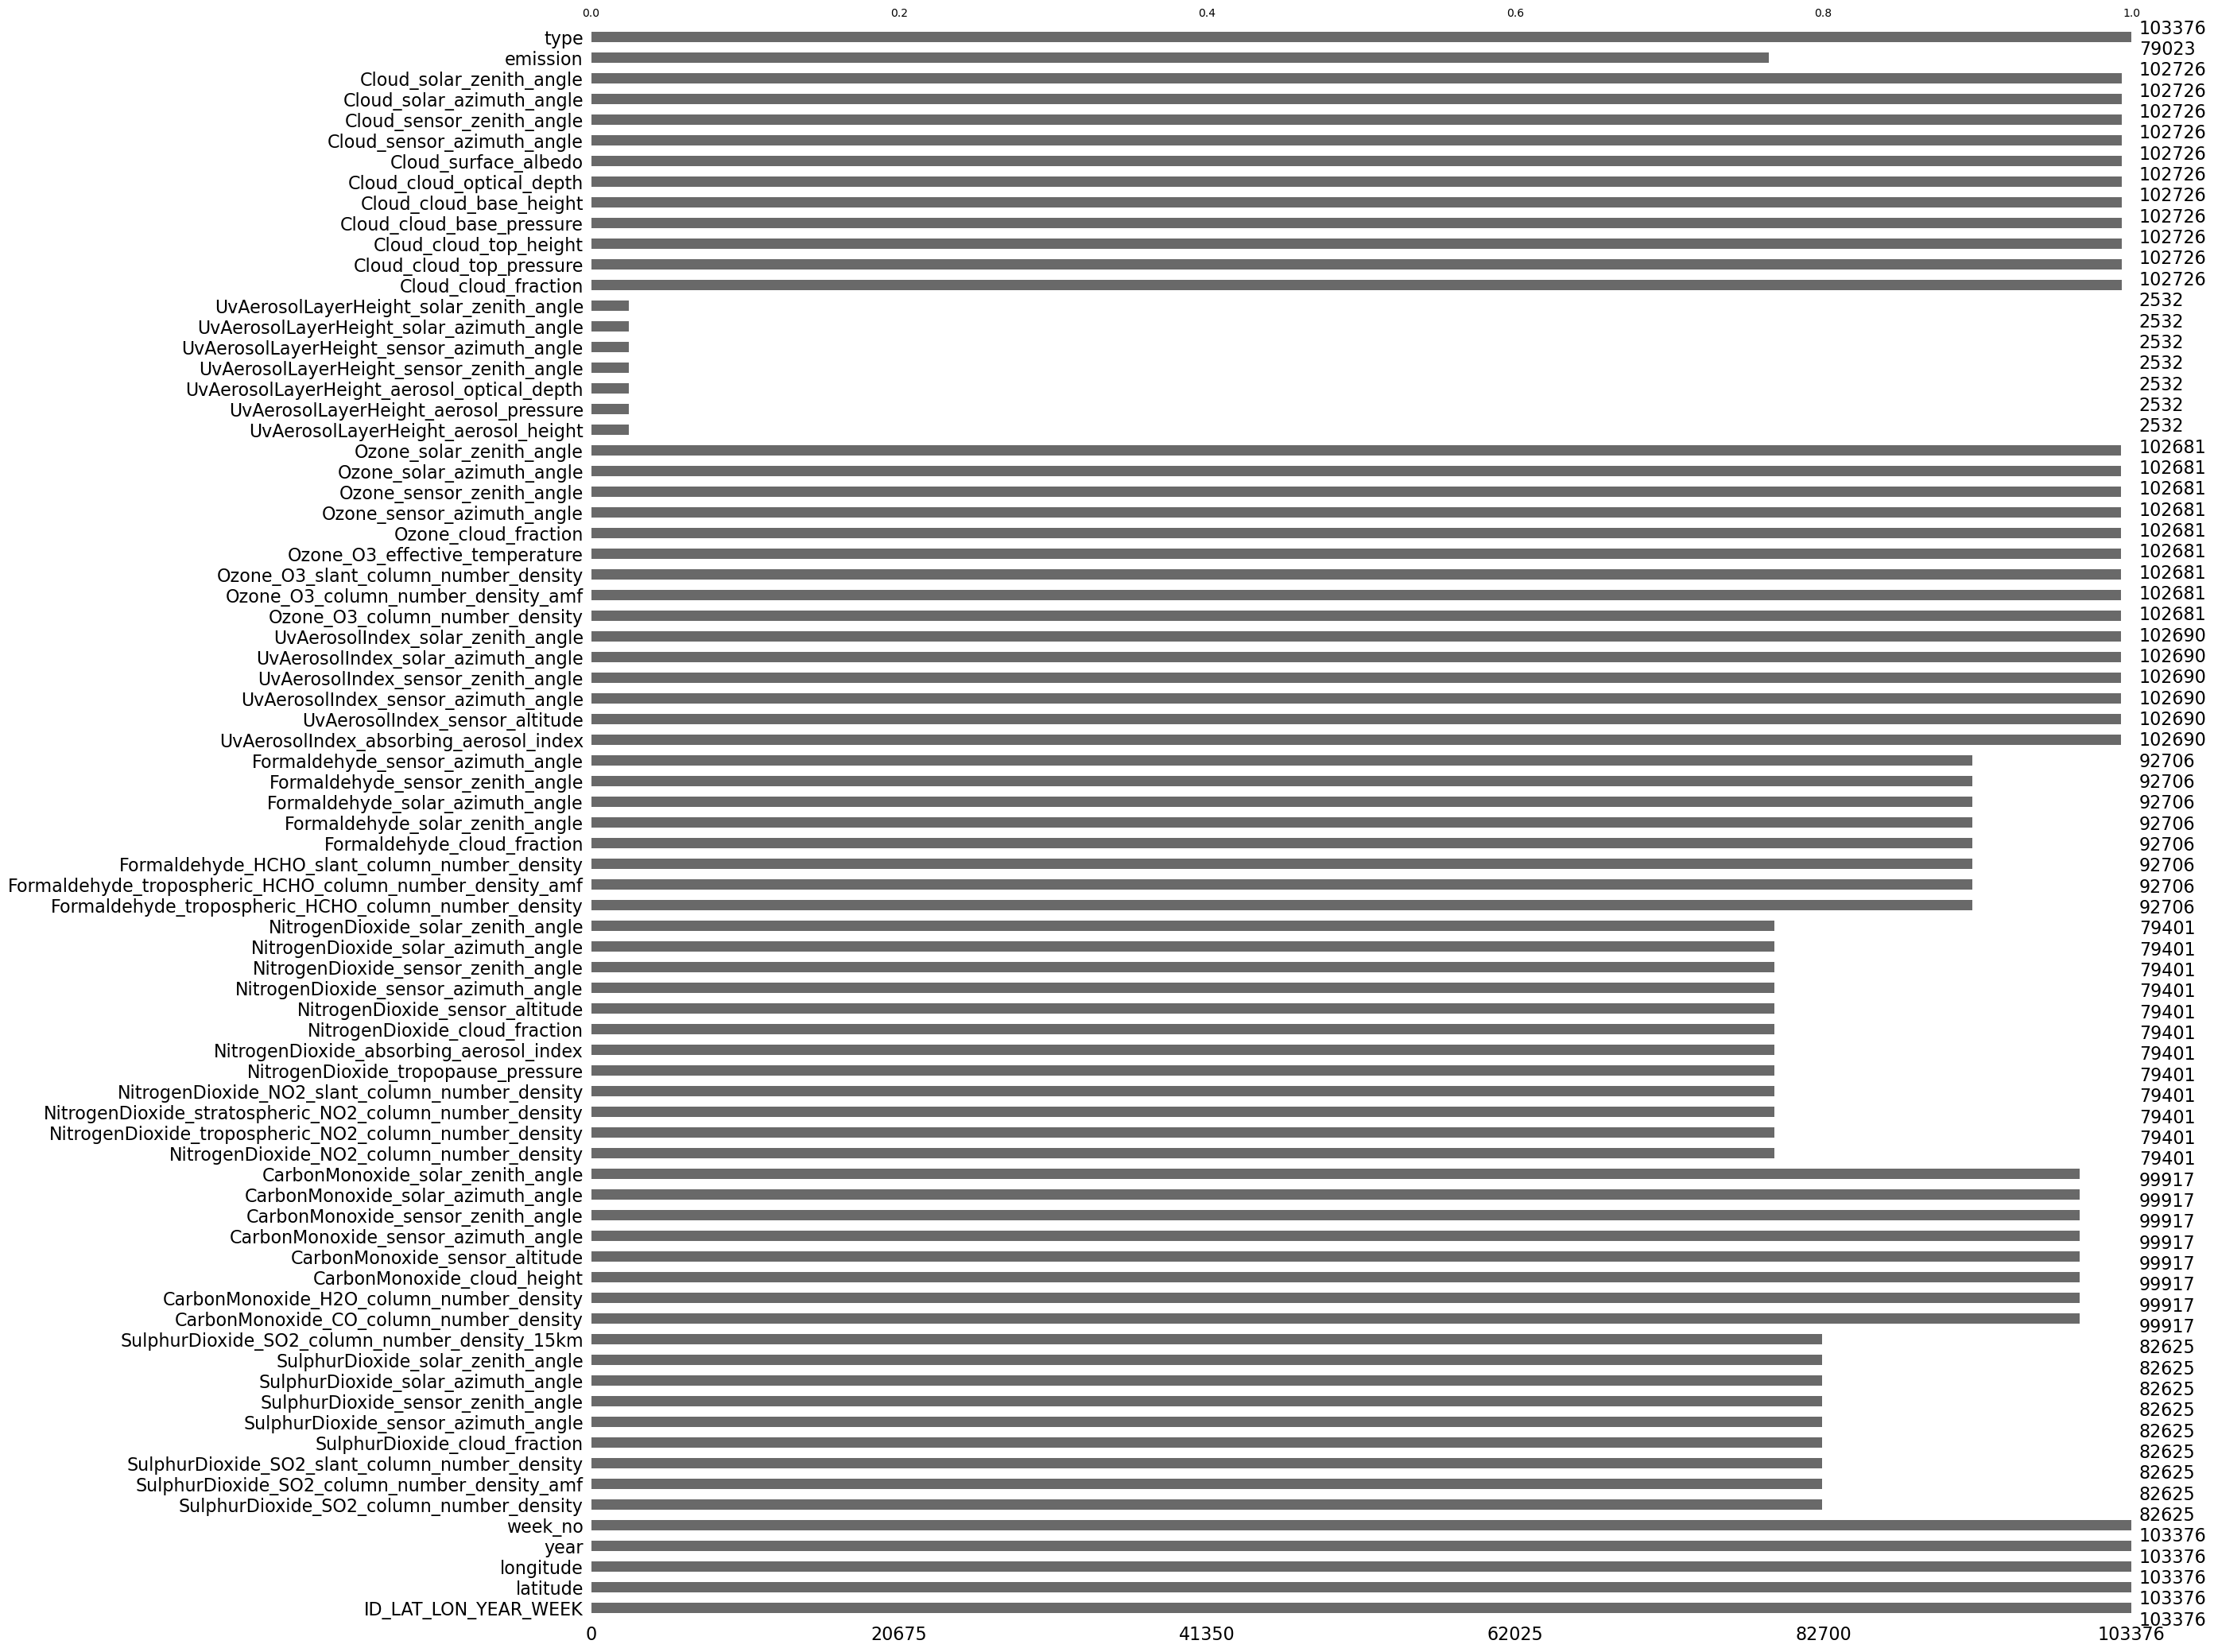

In [12]:
msno.bar(df)

<Axes: >

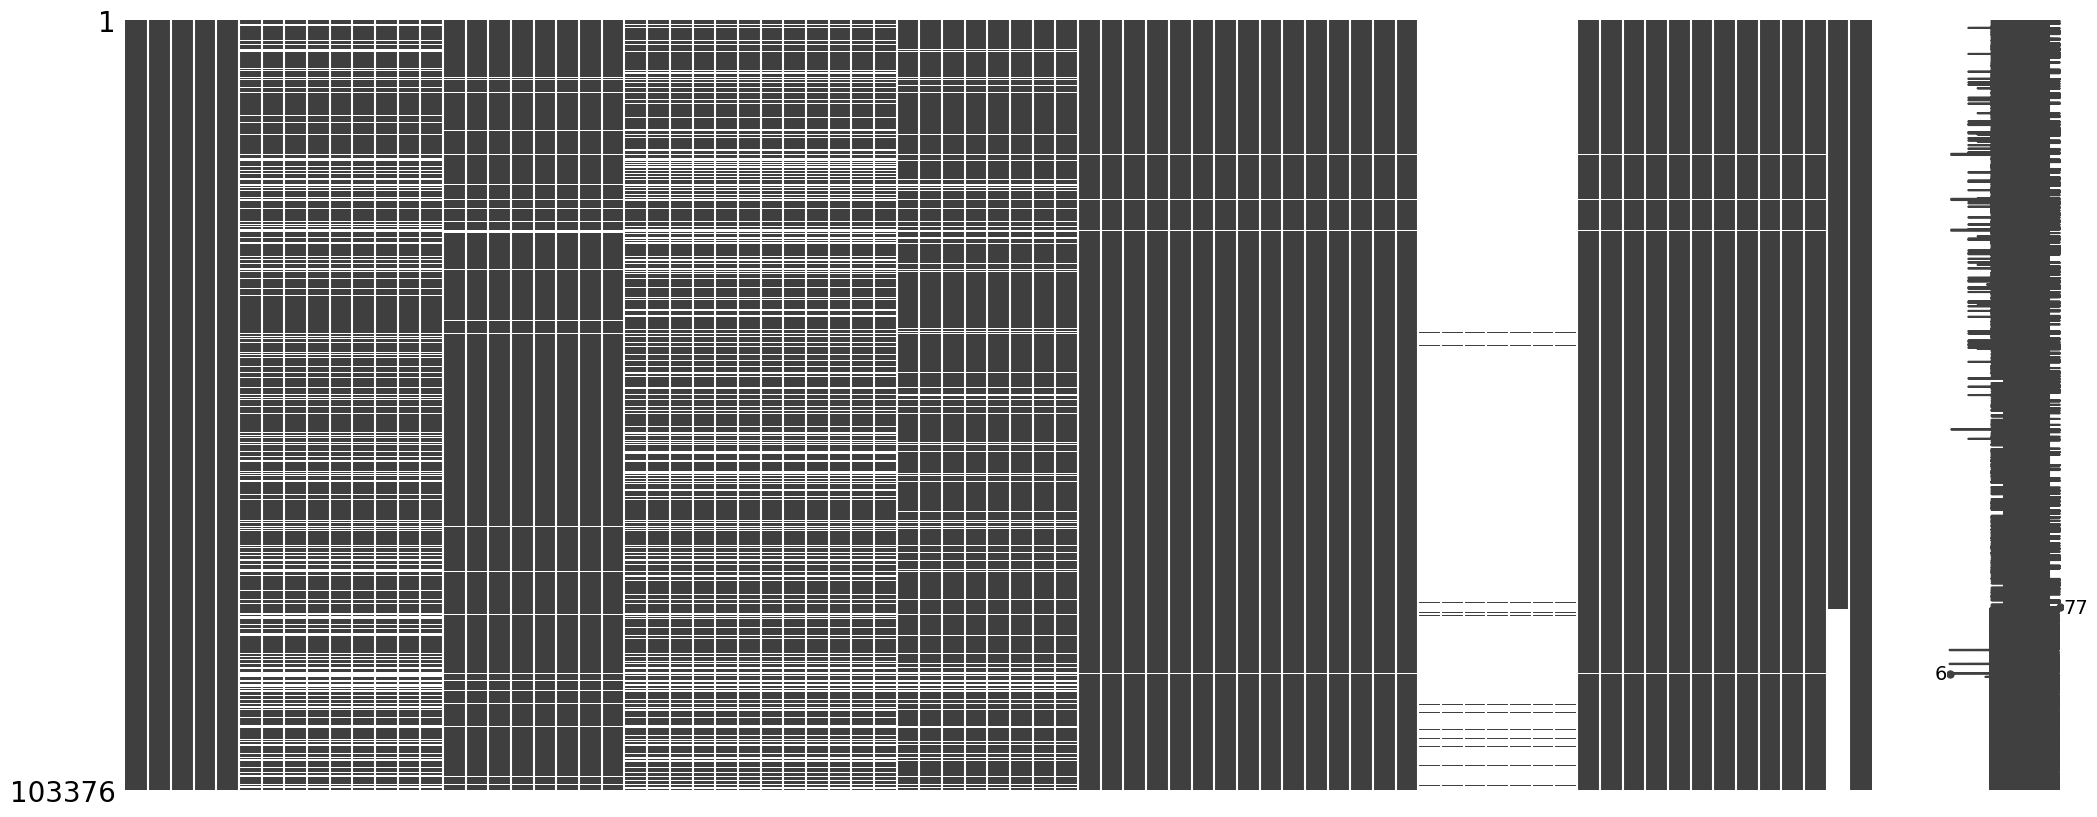

In [13]:
msno.matrix(df)

INFERENCE 
1. So we can see that there are 74 features for both the train and test sets
1. Out of which 4 features are used for indexing and the rest are the satellite features
1. The datatypes are all numerical, there is no categorical datatype
1. Missing Values: In both the train and test set we have about 90+% missing values in the columns that contain "UvAerosolLayerHeight", so we will drop these columns.... as for the other columns, we will see if they have some correlation to the target and how much of an impact they have on the rmse 


#### After experimenting with basic models and checking for correlation with emissions, we arrive at conclusion that the satellite info is not that helpful and only seasonality is seen to be imp hence we can also drop all those columns

### Distribution of CO2 Emission

In [14]:
fig = go.Figure()

fig = go.Figure(data=[go.Histogram(
    x=train['emission'], 
    name='CO2 Emission Distribution', 
    marker_color='seagreen')])

fig.update_layout( 
    title_text="CO2 Emission Distributions",
    template='plotly_dark')

fig.show()

The Distribution seems to be right skewed

###  Distribution of CO2 Emission across Year

In [15]:
fig = go.Figure()

emission_by_time = train.groupby(['year', 'week_no'])['emission'].mean()

fig.add_trace(go.Scatter(x=emission_by_time.loc[2019].index.astype('str'), y=emission_by_time.loc[2019],
                        mode='lines',
                        name='CO2 Emission in 2019',
                        line=dict(color='#008080')))

fig.add_trace(go.Scatter(x=emission_by_time.loc[2020].index.astype('str'), y=emission_by_time.loc[2020],
                        mode='lines',
                        name='CO2 Emission in 2020',
                        line=dict(color='#D0EFB1')))

fig.add_trace(go.Scatter(x=emission_by_time.loc[2021].index.astype('str'), y=emission_by_time.loc[2021],
                        mode='lines',
                        name='CO2 Emission in 2021',
                        line=dict(color='#BFBDC1')))

fig.update_layout(
    title_text='Average CO2 Emissions across Year',
    template='plotly_dark'
)

fig.show()

It seems that the year 2020 as expected has significantly lower carbon emission compared to the other years...more specifically the second quarter of the year (weeks 12-26). This can be attributed to the impact of COVID-19

In [16]:
# The number of weeks in both test and train... they are numbered from 0-49,52 tho
df[df['type']=="test"].week_no.nunique(), df[df['type']=="train"].week_no.nunique()

(49, 53)

## Data Preprocessing

In [17]:
#We will only be selecting the features with high importance and relation to the target
df = df[['latitude', 'longitude', 'year', 'week_no','emission','type']]

In [18]:
df.columns

Index(['latitude', 'longitude', 'year', 'week_no', 'emission', 'type'], dtype='object')

In [19]:
df

,latitude,longitude,year,week_no,emission,type
0,-0.510,29.290,2019,0,3.750994,train
1,-0.510,29.290,2019,1,4.025176,train
2,-0.510,29.290,2019,2,4.231381,train
3,-0.510,29.290,2019,3,4.305286,train
4,-0.510,29.290,2019,4,4.347317,train
...,...,...,...,...,...,...
103371,-3.299,30.301,2022,44,NaN,test
103372,-3.299,30.301,2022,45,NaN,test
103373,-3.299,30.301,2022,46,NaN,test
103374,-3.299,30.301,2022,47,NaN,test


In [20]:
# Giving each location a unique ID
df['id'] = df['latitude'].astype(str)+ df['longitude'].astype(str)
df['id'] = df['id'].map({val: i for i, val in enumerate(df['id'].unique())})

In [21]:
#Doing cartesian rotation on the longitude and latitude coordinates
def rotations(df):
    df['rot_15_x'] = (np.cos(np.radians(15))*df['longitude']) + (np.sin(np.radians(15))*df['latitude'])
    df['rot_15_y'] = (np.cos(np.radians(15))*df['latitude']) + (np.sin(np.radians(15))*df['longitude'])
    df['rot_30_x'] = (np.cos(np.radians(30))*df['longitude']) + (np.sin(np.radians(30))*df['latitude'])
    df['rot_30_y'] = (np.cos(np.radians(30))*df['latitude']) + (np.sin(np.radians(30))*df['longitude'])
    return df
df = rotations(df)

In [22]:
#PCA transformed latitude and longitude to help tree splits in tree-based models
def pca(df):
    coordinates = df[['latitude','longitude']].values
    pca_obj = PCA().fit(coordinates)
    df['pca_x'] = pca_obj.transform(df[['latitude', 'longitude']])[:,0]
    df['pca_y'] = pca_obj.transform(df[['latitude', 'longitude']])[:,1]
    return df
df = pca(df)

In [23]:
# Extracting month from the week_no
month = {i: dt.datetime.strptime(f'{df["year"][i]}-{df["week_no"][i]+1}-1', "%Y-%W-%w").month for i in df.index}
df['month'] = df.index.map(month)

In [24]:
# Applying sine, cosine transformations inorder to let the model know that there is cyclicity
def cyclic_transformation(df):
    df['sin_month'] = np.sin(2 * np.pi * df.month/12)
    df['cos_month'] = np.cos(2 * np.pi * df.month/12)
    df['sin_week_no'] = np.sin(2 * np.pi * df.week_no/53)
    df['cos_week_no'] = np.cos(2 * np.pi * df.week_no/53)
    return df
df = cyclic_transformation(df)

In [25]:
# These are important points in the area surrounding the locations given
rwanda_center = (-1.9607, 29.9707)
park_biega = (-1.8866, 28.4518) 
kirumba = (-0.5658, 29.1714) 
massif = (-2.9677, 28.6469)
lake = (-1.9277, 31.4346)
mbarara = (-0.692, 30.602)
muy = (-2.8374, 30.3346)

# We will calculate the distance using the haversine formula 
# As we are working with geographical data, measurements of nearby locations can help to predict the target.
for col, coors in zip(
    ['dist_rwanda', 'dist_park', 'dist_kirumba', 'dist_massif', 'dist_lake', 'dist_mbarara', 'dist_muy'], 
    [rwanda_center, park_biega, kirumba, massif, lake, mbarara, muy]):
    df[col] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), coors, unit='ft'), axis=1)

### Lets Plot these key points on the map for visualization

In [26]:
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
geometry = gpd.points_from_xy(train_coords['longitude'], train_coords['latitude'])
geo_df = gpd.GeoDataFrame(train_coords[["latitude", "longitude"]], geometry=geometry)

all_data_map = folium.Map(prefer_canvas=True)
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

def rgba_to_hex(color):
    red, green, blue, alpha = color
    return f"#{int(red*255):02x}{int(green*255):02x}{int(blue*255):02x}"

temp = train.groupby(['latitude', 'longitude']).emission.mean().reset_index()
geometry = gpd.points_from_xy(temp['longitude'], temp['latitude'])

cmap = matplotlib.colormaps['coolwarm']
normalizer = matplotlib.colors.Normalize(vmin=np.log1p(temp['emission'].min()), vmax=np.log1p(temp['emission'].max()))

all_data_map = folium.Map(prefer_canvas=True)
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geometry]

for coordinates, emission in zip(geo_df_list, temp['emission']):
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius=1,
            weight=4,
            zoom=10,
            color=rgba_to_hex(cmap(normalizer(np.log1p(emission))))),
        )
all_data_map.fit_bounds(all_data_map.get_bounds())

for color, coors in zip(
    ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'], 
    [rwanda_center, park_biega, kirumba, massif, lake, mbarara, muy]
):
    all_data_map.add_child(
        folium.features.CircleMarker(
            coors, 
            radius=8,
            color=color,
            fill_color=color
        )
    )

all_data_map

In [27]:
# We need to account for the covid year and also the public holidays 
df['is_covid'] = (df['year'] == 2020) & (df['month'] > 2) | (df['year'] == 2021) & (df['month'] == 1)
df['is_lockdown'] = (df['year'] == 2020) & ((df['month'].isin([3,4])))
df['is_covid_peak'] = (df['year'] == 2020) & ((df['month'].isin([4,5,6])))
df['is_covid_dis_peak'] = (df['year'] == 2021) & ((df['month'].isin([7,8,9])))
df['public_holidays'] = (df['week_no'].isin([0, 51, 12, 30]))
df.fillna(0, inplace=True)

In [28]:
# We apply K-means clustering to the emissions from 497 unique locations (each with its own latitude and longitude), which will help us to clearly see the changes in emissions over time.
def cluster_features(df, cluster_centers):
    for i, cc in enumerate(cluster_centers.values()):
        df[f'cluster_{i}'] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), cc, unit='ft'), axis=1)
    return df

coordinates = df[['latitude', 'longitude']].values
clustering = KMeans(n_clusters=12, max_iter=1000, random_state=seed).fit(coordinates)
cluster_centers = {i: tuple(centroid) for i, centroid in enumerate(clustering.cluster_centers_)}
df = cluster_features(df, cluster_centers)

In [29]:
# There happens to be some neighboring countries besides rawanda in the dataset, we will add them as features
countries = pd.read_csv('/kaggle/input/pgs320-country-location-data/location_lat_long.csv')
countries['country'] = countries['country'].apply(lambda x: x.split(',')[-1].lstrip())

In [30]:
countries['id'] = countries.index
countries

,country,latitude,longitude,id
0,République démocratique du Congo,-0.510,29.290,0
1,République démocratique du Congo,-0.528,29.472,1
2,République démocratique du Congo,-0.547,29.653,2
3,Uganda,-0.569,30.031,3
4,République démocratique du Congo,-0.598,29.102,4
...,...,...,...,...
492,Burundi,-3.153,30.347,492
493,République démocratique du Congo,-3.161,28.839,493
494,Burundi,-3.174,29.926,494
495,Burundi,-3.287,29.713,495


In [31]:
countries.loc[countries['country']=='République démocratique du Congo', 'country'] = 'Congo'
df = df.merge(countries[['id', 'country']], on='id', how='left')
le = LabelEncoder()
df['country'] = le.fit_transform(df['country'])
df = pd.concat([df, pd.get_dummies(df['country'], prefix='country')], axis=1)
df.drop('country', axis=1, inplace=True)

In [32]:
df

,latitude,longitude,year,week_no,emission,type,id,rot_15_x,rot_15_y,rot_30_x,rot_30_y,pca_x,pca_y,month,sin_month,cos_month,sin_week_no,cos_week_no,dist_rwanda,dist_park,dist_kirumba,dist_massif,dist_lake,dist_mbarara,dist_muy,is_covid,is_lockdown,is_covid_peak,is_covid_dis_peak,public_holidays,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,country_0,country_1,country_2,country_3,country_4
0,-0.510,29.290,2019,0,3.750994,train,0,28.159970,7.088188,25.110884,14.203327,-0.141790,1.495172,1,5.000000e-01,0.866025,0.000000,1.000000,584571.873900,587934.30305,4.781470e+04,926756.543857,937709.613280,483191.976092,930588.397671,False,False,False,False,True,721772.305096,800818.670892,756230.098965,549268.599378,265052.898110,951194.369978,474670.446944,829838.832371,535113.361542,811424.116943,554046.663412,223696.121638,0,1,0,0,0
1,-0.510,29.290,2019,1,4.025176,train,0,28.159970,7.088188,25.110884,14.203327,-0.141790,1.495172,1,5.000000e-01,0.866025,0.118273,0.992981,584571.873900,587934.30305,4.781470e+04,926756.543857,937709.613280,483191.976092,930588.397671,False,False,False,False,False,721772.305096,800818.670892,756230.098965,549268.599378,265052.898110,951194.369978,474670.446944,829838.832371,535113.361542,811424.116943,554046.663412,223696.121638,0,1,0,0,0
2,-0.510,29.290,2019,2,4.231381,train,0,28.159970,7.088188,25.110884,14.203327,-0.141790,1.495172,1,5.000000e-01,0.866025,0.234886,0.972023,584571.873900,587934.30305,4.781470e+04,926756.543857,937709.613280,483191.976092,930588.397671,False,False,False,False,False,721772.305096,800818.670892,756230.098965,549268.599378,265052.898110,951194.369978,474670.446944,829838.832371,535113.361542,811424.116943,554046.663412,223696.121638,0,1,0,0,0
3,-0.510,29.290,2019,3,4.305286,train,0,28.159970,7.088188,25.110884,14.203327,-0.141790,1.495172,1,5.000000e-01,0.866025,0.348202,0.937420,584571.873900,587934.30305,4.781470e+04,926756.543857,937709.613280,483191.976092,930588.397671,False,False,False,False,False,721772.305096,800818.670892,756230.098965,549268.599378,265052.898110,951194.369978,474670.446944,829838.832371,535113.361542,811424.116943,554046.663412,223696.121638,0,1,0,0,0
4,-0.510,29.290,2019,4,4.347317,train,0,28.159970,7.088188,25.110884,14.203327,-0.141790,1.495172,2,8.660254e-01,0.500000,0.456629,0.889657,584571.873900,587934.30305,4.781470e+04,926756.543857,937709.613280,483191.976092,930588.397671,False,False,False,False,False,721772.305096,800818.670892,756230.098965,549268.599378,265052.898110,951194.369978,474670.446944,829838.832371,535113.361542,811424.116943,554046.663412,223696.121638,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103371,-3.299,30.301,2022,44,0.000000,test,496,28.414674,4.655887,24.591936,12.293482,0.303341,-1.437830,11,-5.000000e-01,0.866025,-0.875735,0.482792,502848.501456,848317.67602,1.078804e+06,614536.968187,648791.362664,957377.617909,168842.053880,False,False,False,False,False,369408.103780,629394.114898,792900.231312,565733.099042,841140.318949,150376.963482,844969.050196,368910.477592,616935.151411,532489.727054,816322.514475,901896.459852,1,0,0,0,0
103372,-3.299,30.301,2022,45,0.000000,test,496,28.414674,4.655887,24.591936,12.293482,0.303341,-1.437830,11,-5.000000e-01,0.866025,-0.812487,0.582979,502848.501456,848317.67602,1.078804e+06,614536.968187,648791.362664,957377.617909,168842.053880,False,False,False,False,False,369408.103780,629394.114898,792900.231312,565733.099042,841140.318949,150376.963482,844969.050196,368910.477592,616935.151411,532489.727054,816322.514475,901896.459852,1,0,0,0,0
103373,-3.299,30.301,2022,46,0.000000,test,496,28.414674,4.655887,24.591936,12.293482,0.303341,-1.437830,11,-5.000000e-01,0.866025,-0.737833,0.674983,502848.501456,848317.67602,1.078804e+06,614536.968187,648791.36

In [33]:
df.drop(columns=['type'], inplace=True)
train = df.iloc[:-len(test),:]
test = df.iloc[-len(test):,:]

In [34]:
test.drop(columns=['emission','id'], inplace=True)

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79023 entries, 0 to 79022
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   latitude           79023 non-null  float64
 1   longitude          79023 non-null  float64
 2   year               79023 non-null  int64  
 3   week_no            79023 non-null  int64  
 4   emission           79023 non-null  float64
 5   id                 79023 non-null  int64  
 6   rot_15_x           79023 non-null  float64
 7   rot_15_y           79023 non-null  float64
 8   rot_30_x           79023 non-null  float64
 9   rot_30_y           79023 non-null  float64
 10  pca_x              79023 non-null  float64
 11  pca_y              79023 non-null  float64
 12  month              79023 non-null  int64  
 13  sin_month          79023 non-null  float64
 14  cos_month          79023 non-null  float64
 15  sin_week_no        79023 non-null  float64
 16  cos_week_no        790

In [36]:
# Assigning feature and target variables
X = train.drop(columns = ['emission','id'])
y = train[['emission']]

* QuantileTransfromer will change distribution of each feature to match the normal distribution which is prefered by ML models not only that but it will help to lessen the impact of outliers on our model. 
* We will also apply standardscaler to help standardize the features

In [37]:
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    QuantileTransformer(output_distribution='normal', random_state=seed), # normalizes columns
    StandardScaler()
)

In [38]:
X = pd.DataFrame(pipeline.fit_transform(X), columns=pipeline.get_feature_names_out())
X.head()

,latitude,longitude,year,week_no,rot_15_x,rot_15_y,rot_30_x,rot_30_y,pca_x,pca_y,month,sin_month,cos_month,sin_week_no,cos_week_no,dist_rwanda,dist_park,dist_kirumba,dist_massif,dist_lake,dist_mbarara,dist_muy,is_covid,is_lockdown,is_covid_peak,is_covid_dis_peak,public_holidays,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,country_0,country_1,country_2,country_3,country_4
0,4.983604,-0.620657,-1.22671,-3.876216,-0.253761,1.652257,0.176701,1.002301,-0.110028,2.57384,-2.275760,0.181152,0.515888,-0.003843,3.511383,1.584388,0.018446,-2.610564,0.808217,0.944838,-0.28617,2.592636,-0.667424,-0.244949,-0.298398,-0.298398,3.500000,2.405573,0.686224,0.490707,0.866691,-0.730476,2.655429,0.023382,1.460838,0.799941,1.139695,0.060548,-1.16274,-0.387896,1.743746,-0.685867,-0.441261,-0.401516
1,4.983604,-0.620657,-1.22671,-1.437373,-0.253761,1.652257,0.176701,1.002301,-0.110028,2.57384,-2.275760,0.181152,0.515888,0.062984,1.157579,1.584388,0.018446,-2.610564,0.808217,0.944838,-0.28617,2.592636,-0.667424,-0.244949,-0.298398,-0.298398,-0.285714,2.405573,0.686224,0.490707,0.866691,-0.730476,2.655429,0.023382,1.460838,0.799941,1.139695,0.060548,-1.16274,-0.387896,1.743746,-0.685867,-0.441261,-0.401516
2,4.983604,-0.620657,-1.22671,-1.257091,-0.253761,1.652257,0.176701,1.002301,-0.110028,2.57384,-2.275760,0.181152,0.515888,0.134145,1.011289,1.584388,0.018446,-2.610564,0.808217,0.944838,-0.28617,2.592636,-0.667424,-0.244949,-0.298398,-0.298398,-0.285714,2.405573,0.686224,0.490707,0.866691,-0.730476,2.655429,0.023382,1.460838,0.799941,1.139695,0.060548,-1.16274,-0.387896,1.743746,-0.685867,-0.441261,-0.401516
3,4.983604,-0.620657,-1.22671,-1.126832,-0.253761,1.652257,0.176701,1.002301,-0.110028,2.57384,-2.275760,0.181152,0.515888,0.206550,0.896975,1.584388,0.018446,-2.610564,0.808217,0.944838,-0.28617,2.592636,-0.667424,-0.244949,-0.298398,-0.298398,-0.285714,2.405573,0.686224,0.490707,0.866691,-0.730476,2.655429,0.023382,1.460838,0.799941,1.139695,0.060548,-1.16274,-0.387896,1.743746,-0.685867,-0.441261,-0.401516
4,4.983604,-0.620657,-1.22671,-1.028813,-0.253761,1.652257,0.176701,1.002301,-0.110028,2.57384,-0.463579,0.348944,0.189109,0.282969,0.765708,1.584388,0.018446,-2.610564,0.808217,0.944838,-0.28617,2.592636,-0.667424,-0.244949,-0.298398,-0.298398,-0.285714,2.405573,0.686224,0.490707,0.866691,-0.730476,2.655429,0.023382,1.460838,0.799941,1.139695,0.060548,-1.16274,-0.387896,1.743746,-0.685867,-0.441261,-0.401516


## Modelling 

In [39]:
# We will do cross validation
sorted_train = train.sort_values(['year', 'week_no']) # TimeSeriesSplit needs the data sorted by timestamp

def do_cross_validation(kf):
    print(type(kf).__name__)
    for i in ("rf", "cat"):
        score_list = []
        for fold, (idx_tr, idx_va) in enumerate(kf.split(sorted_train, groups=sorted_train.year)):
            X_tr = sorted_train.iloc[idx_tr][['longitude', 'latitude', 'week_no']]
            y_tr = sorted_train.iloc[idx_tr]['emission']
            X_va = sorted_train.iloc[idx_va][['longitude', 'latitude', 'week_no']]
            y_va = sorted_train.iloc[idx_va]['emission']

            if i=="rf":
                model = RandomForestRegressor(n_estimators=3000, random_state=seed, n_jobs=-1)
                model.fit(X_tr, y_tr)
            else:
                model = CatBoostRegressor(iterations= 293, learning_rate= 0.2495567335886069, depth= 10, l2_leaf_reg= 5.265277530660612, early_stopping_rounds= 20)
                model.fit(X_tr, y_tr, verbose=False)
            y_va_pred = model.predict(X_va)
            rmse = mean_squared_error(y_va, y_va_pred, squared=False)
            year_tr = set(sorted_train.iloc[idx_tr].year)
            year_va = set(sorted_train.iloc[idx_va].year)
            print(f"Fold {fold}, training on {year_tr}, validating on {year_va}: rmse = {rmse:.2f}")
            score_list.append(rmse)

        print(f"Overall RMSE: {sum(score_list) / len(score_list):.2f}")
        print()

do_cross_validation(LeaveOneGroupOut())
do_cross_validation(TimeSeriesSplit(n_splits=2))

LeaveOneGroupOut
Fold 0, training on {2020, 2021}, validating on {2019}: rmse = 20.27
Fold 1, training on {2019, 2021}, validating on {2020}: rmse = 27.18
Fold 2, training on {2019, 2020}, validating on {2021}: rmse = 18.87
Overall RMSE: 22.11

Fold 0, training on {2020, 2021}, validating on {2019}: rmse = 21.65
Fold 1, training on {2019, 2021}, validating on {2020}: rmse = 27.25
Fold 2, training on {2019, 2020}, validating on {2021}: rmse = 20.17
Overall RMSE: 23.02

TimeSeriesSplit
Fold 0, training on {2019}, validating on {2020}: rmse = 29.12
Fold 1, training on {2019, 2020}, validating on {2021}: rmse = 18.87
Overall RMSE: 24.00

Fold 0, training on {2019}, validating on {2020}: rmse = 29.42
Fold 1, training on {2019, 2020}, validating on {2021}: rmse = 20.17
Overall RMSE: 24.79



In [40]:
# We will use optuna for finding the best parameters 
# def objective(trial):
#     model = CatBoostRegressor(iterations = trial.suggest_int('iterations', 100, 300),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
#         depth = trial.suggest_int('depth', 1, 10), # depth above 10 usually introduces overfitting
#         l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.2, 10),
#         early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 1, 20),
#         loss_function='RMSE')
#     model.fit(X_train, y_train, eval_set=[( X_train, y_train), ( X_test, y_test)], verbose=False)
#     y_pred = model.predict(X_test)
#     return mean_squared_error(y_test, y_pred, squared=False)
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

## On doing CV we get the following scores:
### Using Catboost
#### LeaveOneGroupOut
1. Fold 0, training on {2020, 2021}, validating on {2019}: rmse = 21.65
1. Fold 1, training on {2019, 2021}, validating on {2020}: rmse = 27.25
1. Fold 2, training on {2019, 2020}, validating on {2021}: rmse = 20.17
1. Overall RMSE: 23.02

#### TimeSeriesSplit
1. Fold 0, training on {2019}, validating on {2020}: rmse = 29.42
1. Fold 1, training on {2019, 2020}, validating on {2021}: rmse = 20.17
1. Overall RMSE: 24.79

#### We get 30.991 as score for catboost on test submission

### Using RandomForestRegressor 
#### LeaveOneGroupOut
1. Fold 0, training on {2020, 2021}, validating on {2019}: rmse = 20.27
1. Fold 1, training on {2019, 2021}, validating on {2020}: rmse = 27.18
1. Fold 2, training on {2019, 2020}, validating on {2021}: rmse = 18.87
1. Overall RMSE: 22.11

#### TimeSeriesSplit
1. Fold 0, training on {2019}, validating on {2020}: rmse = 29.12
1. Fold 1, training on {2019, 2020}, validating on {2021}: rmse = 18.87
1. Overall RMSE: 24.00

#### We get 31.57 as score for randomforestregressor on test submission

In [41]:
# best_hyperparams = study.best_params
# best_score = study.best_value
# print(best_hyperparams)
# print(best_score)

In [42]:
# model = CatBoostRegressor(**best_hyperparams)
# model.fit(X_train, y_train, eval_set=[( X_train, y_train), ( X_test, y_test)], verbose=False)
# y_pred = model.predict(X_test)
# print(mean_squared_error(y_test, y_pred, squared=False))

In [43]:
predictions = np.zeros(len(test))

In [44]:
test = pd.DataFrame(data=pipeline.transform(test), columns=pipeline.get_feature_names_out())

In [45]:
# Fitting the Catboost model on the train data
model = CatBoostRegressor(iterations= 293, learning_rate= 0.2495567335886069, depth= 10, l2_leaf_reg= 5.265277530660612, early_stopping_rounds= 20)
model.fit(X,y, verbose=False)

### We will use an ensemble of the catboost model and the randomforestregressor model to return the final predictions

In [46]:
# We're assigning the catboost model more weigth since it gets a better rmse score on the test set
predictions += model.predict(test) * 0.65
del model

In [47]:
# Fitting the randomforest model on the train data
model = RandomForestRegressor(n_estimators=3000, random_state=seed, n_jobs=-1)
model.fit(X,y)

RandomForestRegressor(n_estimators=3000, n_jobs=-1, random_state=42)

In [48]:
predictions += model.predict(test) * 0.35
del model

In [49]:
submission['id'] = np.array(train[(train['week_no']<49)&(train['year']==2021)]['id'])
submission['week_no'] = submission.groupby('id').cumcount()
# Since we are focused on improving the score on the leaderboard, we will need to take into consideration places with really high peaks of emissions as these values can have a really negative impact on the score
submission.loc[submission['id']==293, 'emission'] = np.array(train[(train['id']==293)&(train['year']==2021)&(train['week_no']<49)]['emission'])
# We will now again combine the prediction result received with the max emission value from 2019 to 2021
submission['emission'] = submission['emission']*0.35 + np.max([train[(train['year']==y) & (train['week_no']<49)]['emission'] for y in range(2019, 2022)], axis=0)*0.65

In [50]:
# Here we will combine our predictions with the predictions of another method where the years 2019 and 2020 in the training set will allign with the 2021 data by making the mean and std deviation equal to the 2021 data
submission2 = pd.read_csv('/kaggle/input/align-2019-2020-emission-values-with-2021/submission.csv')
submission['emission'] = (submission['emission'] + submission2['emission']) / 2

In [51]:
submission.drop(['id', 'week_no'], axis=1, inplace=True)

In [52]:
submission

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,17.685793
1,ID_-0.510_29.290_2022_01,17.869243
2,ID_-0.510_29.290_2022_02,17.957162
3,ID_-0.510_29.290_2022_03,17.984553
4,ID_-0.510_29.290_2022_04,18.017890
...,...,...
24348,ID_-3.299_30.301_2022_44,38.869047
24349,ID_-3.299_30.301_2022_45,39.197430
24350,ID_-3.299_30.301_2022_46,39.446733
24351,ID_-3.299_30.301_2022_47,39.709648


In [53]:
train = pd.read_csv("/kaggle/input/playground-series-s3e20/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e20/test.csv")
train['id'] = train['latitude'].astype(str)+ train['longitude'].astype(str)
train['id'] = train['id'].map({val: i for i, val in enumerate(train['id'].unique())})
test['id'] = test['latitude'].astype(str)+ test['longitude'].astype(str)
test['id'] = test['id'].map({val: i for i, val in enumerate(test['id'].unique())})

In [54]:
# Some locations have 0 emissions hence we will make sure the predictions for these locations have 0 as well
locations = list(train.groupby("id")["emission"].mean().sort_values().iloc[:15].keys())
for loc in locations:
    submission.loc[test['id']== loc , 'emission'] = 0

#### Saving the final predictions in a csv file

In [55]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

### We get a final RMSE score of 13.25 on the test set submission.... With the best score in the competition being 9.33